<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_11_5_DQN_GYMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot --quiet

     |████████████████████████████████| 793 kB 7.5 MB/s 
     |████████████████████████████████| 381 kB 56.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
!apt-get install -y xvfb x11-utils
# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            mediapy \
            piglet -q

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,259 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155639 fil

In [ ]:
!echo $DISPLAY

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
import gym.wrappers
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import mediapy 
import random
from collections import deque
from livelossplot import PlotLosses


action space: Discrete(2)
observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


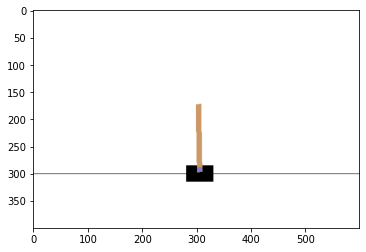

In [ ]:
#@title Setup Environment { run: "auto" }
ENVIRONMENT = "CartPole-v1" #@param ["CartPole-v1", "Acrobot-v1", "CubeCrash-v0", "MountainCar-v0", "LunarLander-v2"]

env = gym.make(ENVIRONMENT)

state = env.reset()
plt.imshow(env.render(mode='rgb_array'))

print("action space: {0!r}".format(env.action_space))
print("observation space: {0!r}".format(env.observation_space))

In [ ]:
#@title Siumlate Environment Run { run: "auto" }
ENVIRONMENT = "LunarLander-v2" #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "LunarLander-v2"]
SIMULATION_RUNS = 10 #@param {type:"slider", min:1, max:10, step:1}
SIMULATION_ITERATIONS = 200 #@param {type:"slider", min:50, max:200, step:1}

env = gym.make(ENVIRONMENT)

fitnesses = []
frames = []

for run in range(SIMULATION_RUNS):  
  state = env.reset()
  fitness = 0
  for i in range(SIMULATION_ITERATIONS):
    action = env.action_space.sample()
    state, reward, done, info = env.step(np.argmax(action))  
    frames.append(env.render(mode='rgb_array'))  
    fitness += reward       
    if done: 
      fitnesses.append(fitness) 
      break 

mediapy.show_video(frames, fps=30)
print(fitnesses)

[-196.77148739560403, -135.52553033559133, -283.936038397615, -104.99771779089096, -42.38143330164897, -160.97305009502418, 37.73748373782337, -106.73690914278887, -113.79550923126052, -53.579669437143735]


In [ ]:
import tensorflow.keras as k
import tensorflow.keras.layers as kl

class DQNAgent():
    def __init__(self, state_size, action_size, episodes=100):
        self.weight_backup      = "backup_weights.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = 0.001
        self.gamma              = 0.95
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.1
        self.exploration_decay  = (self.exploration_rate-self.exploration_min) / episodes      
        self.brain              = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = k.Sequential()
        model.add(kl.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(kl.Dense(24, activation='relu'))
        model.add(kl.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=k.optimizers.Adam(learning_rate=self.learning_rate))

        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        return model

    def save_model(self):
            self.brain.save(self.weight_backup)
            
    def mem_usage(self):
            return len(self.memory)/2000

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))    

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
              target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            target_f = self.brain.predict(state)
            target_f[0][action] = target
            self.brain.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate -= self.exploration_decay

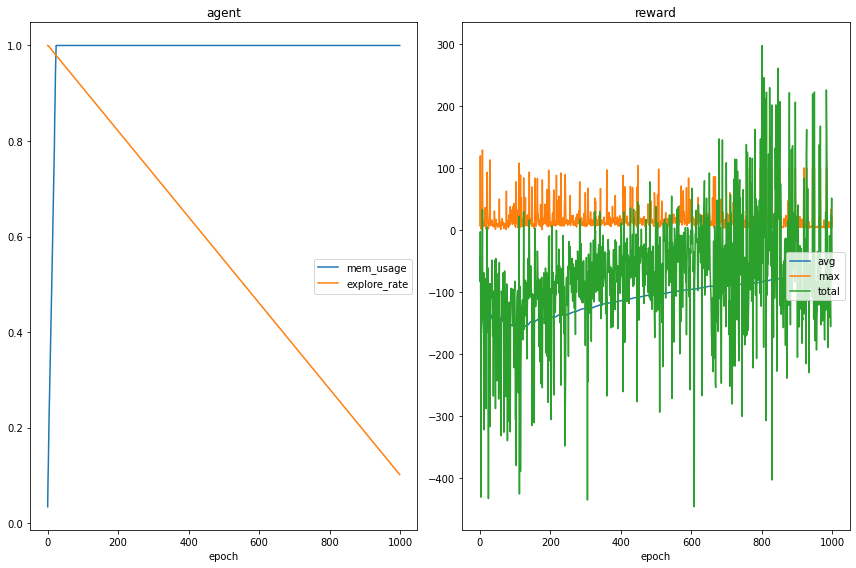

agent
	mem_usage        	 (min:    0.035, max:    1.000, cur:    1.000)
	explore_rate     	 (min:    0.102, max:    1.000, cur:    0.102)
reward
	avg              	 (min: -165.025, max:  -42.808, cur:  -74.925)
	max              	 (min:    0.584, max:  128.944, cur:    4.711)
	total            	 (min: -446.644, max:  297.621, cur:  -55.948)


In [ ]:
#@title Train the Agent
BATCH_SIZE = 256 #@param {type:"slider", min:32, max:256, step:2}
EPISODES = 1000 #@param {type:"slider", min:10, max:1000, step:1}

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, episodes=EPISODES)

groups = { "reward" : {"total", "max", "avg"}, 
          "agent" : {"explore_rate", "mem_usage"}}
plotlosses = PlotLosses(groups=groups)
total_rewards = 0
for ep in nb.tqdm(range(EPISODES)):
  rewards = []
  state = env.reset()
  state = np.reshape(state, [1, state_size])

  done = False
  index = 0
  while not done:    
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    rewards.append(reward)
    next_state = np.reshape(next_state, [1, state_size])
    agent.remember(state, action, reward, next_state, done)
    state = next_state      
  agent.replay(BATCH_SIZE)  
  total_rewards += sum(rewards)
  plotlosses.update({'total': sum(rewards),
                     'max': max(rewards),
                     "avg" : total_rewards/(ep+1),
                     "explore_rate" : agent.exploration_rate,
                     "mem_usage" : agent.mem_usage(),
                     })
  plotlosses.send()

In [ ]:
fitness = 0
frames = []

state = env.reset()
done = False
while not done:  
  state = np.reshape(state, [1, state_size])
  action = agent.act(state)
  next_state, reward, done, _ = env.step(action)  
  state = next_state
  fitness += reward
  frames.append(env.render(mode='rgb_array'))
env.close()

print(fitness)
mediapy.show_video(frames, fps=30)

NameError: ignored